In [1]:
from src import data_loader as dl
from src.data_loader import PVDataLoader
import torch
import numpy as np
from src.plotting import plot_train_test_split, plot_grid

In [56]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 100
N_DAYS_TRAIN = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_HOURS_PRED = 3
N_SYSTEMS = 55
RADIUS = 0.35
COORDS = (55, -1.5)
# create a tuple of 4 coordinates that form a polygon in the uk

POLY_COORDS = ((50, -6), (50.5, 1.9), (57.6, -5.5), (58, 1.9))

In [57]:
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 0 sec



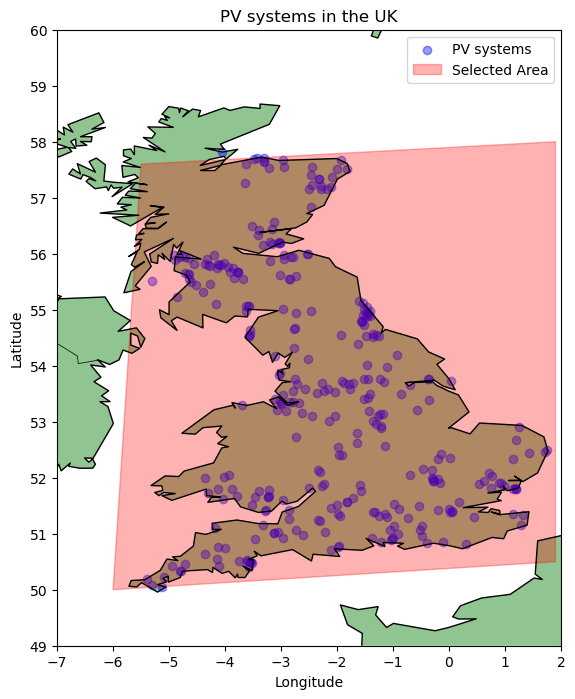

In [58]:
plot_grid(df_location, POLY_COORDS, distance_method='poly')

In [59]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    coords=POLY_COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv',
                    distance_method='poly')

time, y = loader.get_time_series()

==> Loading data
==> Loaded data in: 0 m : 11 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [60]:
periodic_time = dl.periodic_mapping(time, day_min=DAY_MIN, day_max=DAY_MAX, minute_interval=MINUTE_INTERVAL)

In [61]:
def cross_val_folds(y, periodic_time, n_days, daily_points):
    """
    Splits the data into n_days folds
    """
    interval = int(n_days * daily_points)
    y_list = [y[i:i+interval] for i in range(0, len(y), interval)]
    periodic_time_list = [periodic_time[i:i+interval] for i in range(0, len(periodic_time), interval)]
    time = torch.arange(0, len(y_list[0]))

    return y_list, periodic_time_list, time



In [62]:
y_list, periodic_time_list, time = cross_val_folds(y, periodic_time, 5, DAILY_DATA_POINTS)

In [73]:
def train_test_split_fold(y_list, periodic_time_list, n_hours_pred, daily_points, day_min, day_max):
    """ 
    Split the data into train and test sets
    The test set is a random hour between 8 and 16 - N for all folds 
    (where N is the number of hours to predict). That will avoid 
    discontinuity and facilitates predictions at different times of 
    the day.

    Args: 
        y (list): the list of y values
        periodic_time (list): list of periodic times
        n_hours_pred (int): the number of hours to predict
        daily_points (int): the number of data points per day
    """ 
    assert daily_points % (day_max - day_min) == 0, "daily_points must be divisible by day_max - day_min"
    assert len(y_list) == len(periodic_time_list), "y_list and periodic_time_list must have the same length"
    
    y_train = []
    y_test = []
    
    time_train = []
    time_test = []

    periodic_train = []
    periodic_test = []
    
    hourly_data_points = daily_points // (day_max - day_min) 
    
    # indexes going backwards from the end of the array
    min_start_idx = int(n_hours_pred * hourly_data_points)
    max_start_idx = int(daily_points)
    
    for i in range(len(y_list)):

        last_hr_idx = np.random.randint(min_start_idx, max_start_idx)
        start_idx = last_hr_idx + int((n_hours_pred * hourly_data_points))

        y_train.append(y_list[i][:-start_idx])
        y_test.append(y_list[i][-start_idx:-last_hr_idx])

        periodic_train.append(periodic_time_list[i][:-start_idx])
        periodic_test.append(periodic_time_list[i][-start_idx:-last_hr_idx])

        _time = torch.arange(0, len(y_train[-1]) + len(y_test[-1]))

        time_train.append(_time[:-len(y_test[-1])])
        time_test.append(_time[-len(y_test[-1]):])

    return y_train, y_test, periodic_train, periodic_test, time_train, time_test

        
        

In [74]:
y_train, y_test, periodic_train, periodic_test, time_train, time_test =  train_test_split_fold(y_list, periodic_time_list, N_HOURS_PRED, DAILY_DATA_POINTS, DAY_MIN, DAY_MAX)


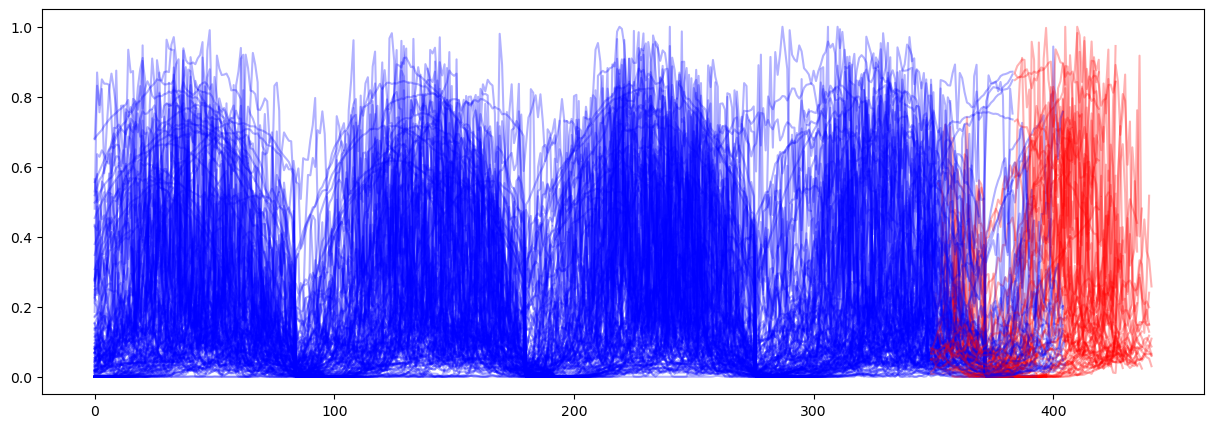

In [76]:
plt.figure(figsize=(15, 5))

for i in range(len(y_test)):
    plt.plot(time_train[i], y_train[i], color='b', alpha=0.3)
    plt.plot(time_test[i], y_test[i], color='r', alpha=0.3)